In [1]:
import pandas as pd
from datetime import datetime, date
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

%matplotlib inline

import os
import pandas as pd
import openpyxl as excel
import glob

In [2]:
dir_ = "/home/reinhold/Daten/Paper_Datasets_Nov2022"
filenames = [r'OpenAPS complete_patient_statistics.xlsx',
    r'OPENonOH complete_patient_statistics.xlsx'] # Specify the file path

df = {}
df["OpenAPS"] = pd.read_excel(os.path.join(dir_, filenames[0]))  # all columns

df["OPENonOH"] = pd.read_excel(os.path.join(dir_, filenames[1]))
print(len(df["OPENonOH"].columns), df["OPENonOH"].columns)

print(sns.__version__)

27 Index([         'id',         'age',      'gender',      'height',
            'weight',     'country',        'year',       'month',
        'interdaysd',  'interdaycv', 'bg_roc_stds',      'TOR<70',
               'TIR',     'TOR>180',         'POR',     'J_index',
              'LGBI',        'HBGI',         'GMI',       'count',
              'mean',         'std',         'min',          0.25,
                 0.5,          0.75,         'max'],
      dtype='object')
0.12.1


In [3]:
#print([p for p in plt.rcParams.keys() if "font" in p])


# Statistical and Variability Metrics for Glucose Analysis from CGM Data

count - total CGM data points

mean - average of CGM data

std	- standard deviation of CGM data

min	- minimum CGM data value

25%	- Q1

50%	- Q2

75%	- Q3 

max - maximum CGM data value

interdaysd - computes interday standard deviation

interdaycv - computes interday coefficient of variation

TORless70 - computes time outside range --> (hypoglycemia | BG < 70 mg/dL) in percentage

TIR - computes time inside range --> (target range | 70 mg/dl < BG < 180 mg/dL) in percentage

TORmore180 - computes time outside range --> (hyperglycemia | BG > 180 mg/dL) in percentage

POR - computes percent of time outside range (range in standard deviations from mean, default = 1). sr is the sampling rate inverse in minutes of the CGM 

J_index - computes the glycemic variability metric, J-index

LBGI - computes glycemic variability metric low blood glucose index

HBGI - computes glycemic variability metric high blood glucose index

GMI - computes glycemic management indicator

In [4]:
df1, df2 = df["OPENonOH"], df["OpenAPS"]
var = "interdaysd"
#print(plt.rcParams.keys())

df1.loc[df1['gender'] == 'Transgender Male',
                        'gender'] = 'Male'
df2.loc[df2['gender'] == 'Transgender Male',
                        'gender'] = 'Male'
df1["project"] = "OPENonOH"
df2["project"] = "OpenAPS\nData Commons"
print(df1.index, df2.index)
df1.reindex(["id"], axis=0)
print(df1.index, df2.index)

df3 = pd.concat([df1, df2], axis=0)
print(df3.loc[df3[["project", "id"]].duplicated(keep=False)])
#df3.reindex(["project", "id"], axis=0)

#h, bin_edges = np.histogram(df1.loc[df1['gender']=='Male',var])
#kernel = gaussian_kde(df1.loc[df1['gender']=='Male',var])
#x = np.linspace(bin_edges[0], bin_edges[-1], 100)
#sns.lineplot(x=x, y=kernel(x)*75*(bin_edges[1]-bin_edges[0]))

#sns.histplot(data=df2,
#            x=var, 
#            hue='gender',
#           palette=["#0672B0", "brown"],
#            linewidth=1, 
#            legend=None)
#plt.hist(df["OpenAPS"][var])


RangeIndex(start=0, stop=75, step=1) RangeIndex(start=0, stop=122, step=1)
RangeIndex(start=0, stop=75, step=1) RangeIndex(start=0, stop=122, step=1)
Empty DataFrame
Columns: [id, age, gender, height, weight, country, year, month, interdaysd, interdaycv, bg_roc_stds, TOR<70, TIR, TOR>180, POR, J_index, LGBI, HBGI, GMI, count, mean, std, min, 0.25, 0.5, 0.75, max, project, Unnamed: 0, mean+std, mean-std, dailyInsulinUnits, dailyBasalInsulinUnits, DIYTech]
Index: []

[0 rows x 34 columns]


# Visualising demographics and calculated metrics
Figure 5 in the gv paper (https://www.mdpi.com/2072-6643/14/9/1906)

In [5]:

def plot_kde_two_distributions(df1, df2, var, xlabel):
    sns.set_theme(context="notebook", style="white")
    #sns.set_theme(rc={'palette': ["#0672B0", "brown"], 'alpha' : 0.5, 'linewidth' : 0.1, 'kde' : True, 'rug':True})

    df1[var] = df1[var].astype(float)
    df2[var] = df2[var].astype(float)

    plt.rcParams.update({'font.size': 24})
    nbins = 8  # number of bins
    fg= sns.displot(df1,
                x=df1[var],
                hue=df1['gender'],
                palette=["brown", "#0672B0"],
                alpha=0.5,
                linewidth=0.1,
                bins=nbins,
                kde=True, 
                rug=True)
    plt.xlabel(xlabel)

    print(len(fg.fig.axes))
    ax = fg.fig.axes[0]
    print(len(ax.get_lines()))
    ax.get_lines().remove(ax.get_lines()[1])
    min_,max_ = ax.get_xlim()
    bin_width = (max_-min_)/nbins
    #print(df2['gender'].unique())
    h,kernel,norm_ = {}, {}, {}
    kernel["Male"] = gaussian_kde(df2.loc[df2['gender']=='Male',var])
    x_ = np.linspace(min_, max_, 100)
    print(df2.loc[df2['gender']=='Female', 'gender'].count())
    norm_["Female"] = df2.loc[df2['gender']=='Female', 'gender'].count()*bin_width  
    norm_["Male"] = df2.loc[df2['gender']=='Male', 'gender'].count()*bin_width  

    kernel["Female"] = gaussian_kde(df2.loc[df2['gender']=='Female',var])
    sns.lineplot(x=x_, y=kernel["Female"](x_)*norm_["Female"], ax=ax, color="brown", linestyle='--', label="F (OpenAPS)")
    sns.lineplot(x=x_, y=kernel["Male"](x_)*norm_["Male"], ax=ax, color="#0672B0", linestyle='--', label="M (OpenAPS)")

    fg.fig.savefig("kde_"+var+".png", bbox_inches='tight')
    #h["Male"], bin_edges["Male"] = np.histogram(df1.loc[df1['gender']=='Male',var])
    #kernel["Male"] = gaussian_kde(df1.loc[df1['gender']=='Male',var])
    #x["Male"] = np.linspace(bin_edges["Male"][0], bin_edges["Male"][-1], 100)
    #norm_ = 75*(bin_edges["Male"][1]-bin_edges["Male"][0])
    #sns.lineplot(x=x["Male"], y=kernel["Male"](x["Male"])*norm_, ax=ax, color="brown")


In [43]:
def plot_kde2(df, var, xlabel, move_legend=False):
    sns.set_theme(context="notebook", style="white")
    #sns.set_theme(rc={'alpha' : 0.5, 'linewidth' : 0.1, 'kde' : True, 'rug':True})
    
    df[var] = df[var].astype(float)

    plt.rcParams.update({'font.size': 24, 'legend.fontsize': 12, 'legend.title_fontsize': 14})
    nbins = 8  # number of bins
    fg= sns.displot(df,
                x=df[var],
                hue=df['project'],
                palette=["brown", "#0672B0"],
                alpha=0.5,
                linewidth=0.1,
                bins=nbins,
                kde=True, 
                rug=True)
    plt.xlabel(xlabel)
    plt.tight_layout()
    if move_legend: 
        sns.move_legend(fg, title="", loc='upper left', bbox_to_anchor=(0.15, 0.85), ncol=1)
    plt.savefig("kde_"+var+"_2.png")


Index([                    'id',                    'age',
                       'gender',                 'height',
                       'weight',                'country',
                         'year',                  'month',
                   'interdaysd',             'interdaycv',
                  'bg_roc_stds',                 'TOR<70',
                          'TIR',                'TOR>180',
                          'POR',                'J_index',
                         'LGBI',                   'HBGI',
                          'GMI',                  'count',
                         'mean',                    'std',
                          'min',                     0.25,
                            0.5,                     0.75,
                          'max',                'project',
                   'Unnamed: 0',               'mean+std',
                     'mean-std',      'dailyInsulinUnits',
       'dailyBasalInsulinUnits',                'DIYTech

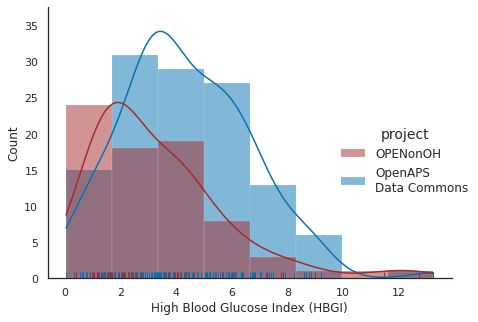

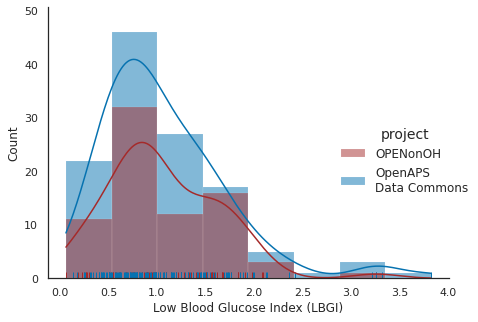

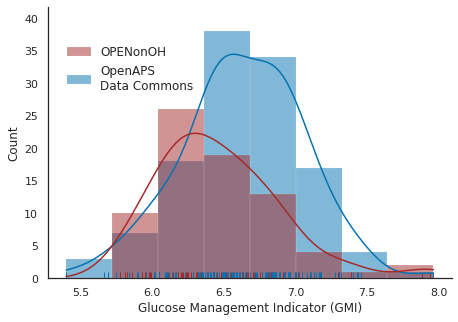

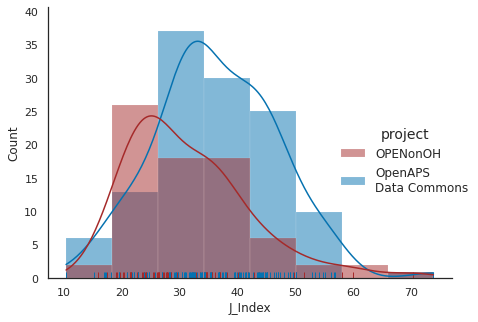

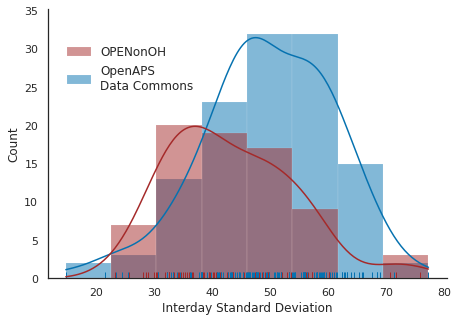

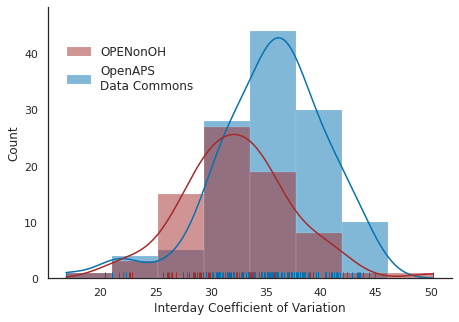

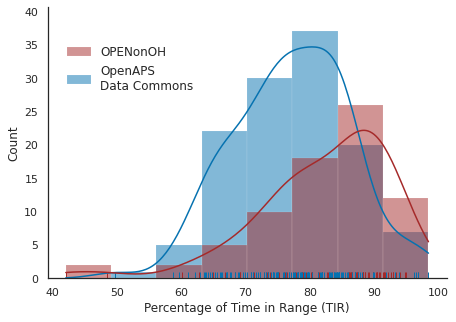

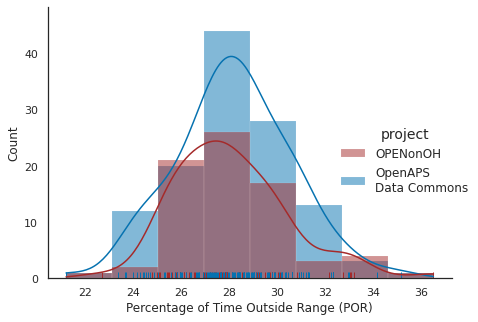

In [44]:
print(df3.columns)
print(df3["project"].unique())
# plot_kde2 does dataset comparison only, no male/female
plot_kde2(df3, 'HBGI', 'High Blood Glucose Index (HBGI)') 
plot_kde2(df3, 'LGBI', 'Low Blood Glucose Index (LBGI)')
plot_kde2(df3, 'GMI', 'Glucose Management Indicator (GMI)', True)
plot_kde2(df3, 'J_index', 'J_Index')
plot_kde2(df3, 'interdaysd', 'Interday Standard Deviation', True)
plot_kde2(df3, 'interdaycv', 'Interday Coefficient of Variation', True)
plot_kde2(df3, 'TIR', 'Percentage of Time in Range (TIR)', True)
plot_kde2(df3, 'POR', 'Percentage of Time Outside Range (POR)')


In [41]:
def plot_kde(df, var, xlabel, move_legend=False):
    sns.set_theme(context="notebook", style="white")
    #sns.set_theme(rc={'alpha' : 0.5, 'linewidth' : 0.1, 'kde' : True, 'rug':True})
    
    df[var] = df[var].astype(float)

    plt.rcParams.update({'font.size': 24, 'legend.fontsize': 12, 'legend.title_fontsize': 14})
    nbins = 8  # number of bins
    fg= sns.displot(df,
                x=df[var],
                hue=df['gender'],
                palette=["brown", "#0672B0"],
                alpha=0.5,
                linewidth=0.1,
                bins=nbins,
                kde=True, 
                rug=True)
    plt.xlabel(xlabel)
    plt.tight_layout()
    if move_legend: 
        sns.move_legend(fg, title="", loc='upper left', bbox_to_anchor=(0.25, 0.85), ncol=1)
    plt.savefig("OPENonOH_gender_kde_"+var+".png")


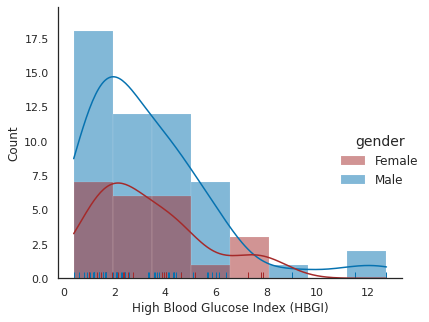

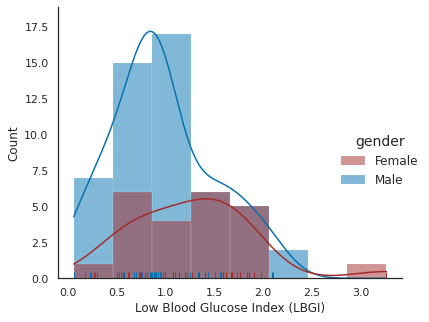

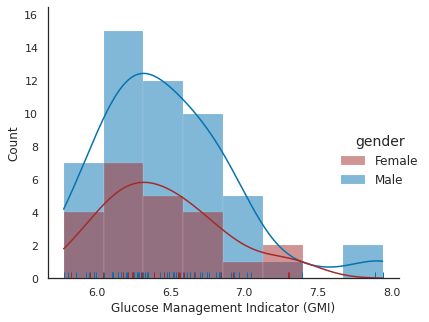

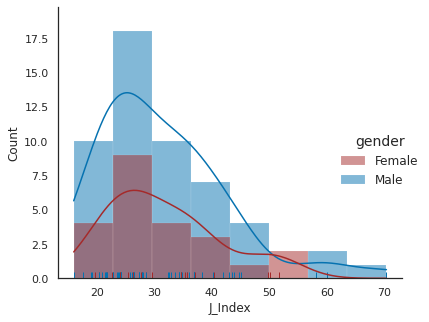

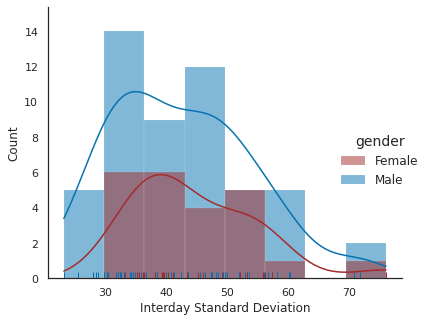

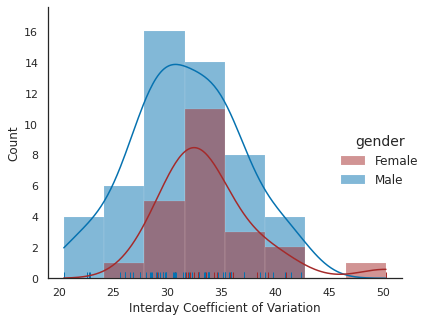

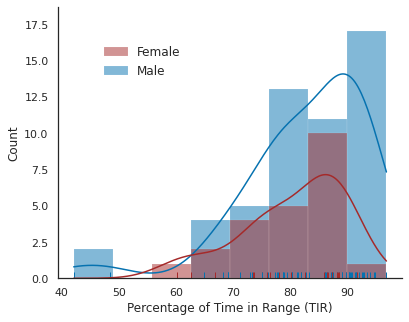

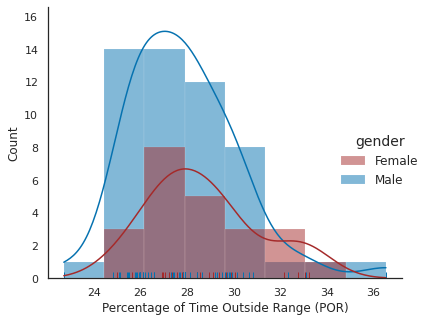

In [42]:
plot_kde(df1, 'HBGI', 'High Blood Glucose Index (HBGI)')
plot_kde(df1, 'LGBI', 'Low Blood Glucose Index (LBGI)')
plot_kde(df1, 'GMI', 'Glucose Management Indicator (GMI)')
plot_kde(df1, 'J_index', 'J_Index')
plot_kde(df1, 'interdaysd', 'Interday Standard Deviation')
plot_kde(df1, 'interdaycv', 'Interday Coefficient of Variation')
plot_kde(df1, 'TIR', 'Percentage of Time in Range (TIR)', True)
plot_kde(df1, 'POR', 'Percentage of Time Outside Range (POR)')


Text(0.5, 15.440000000000012, 'Interday Coefficient of Variation')

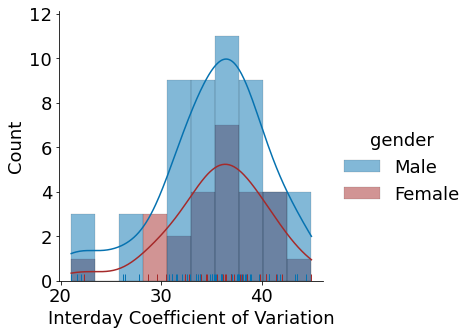

In [17]:
sns.displot(complete_statistics,
            x=complete_statistics['interdaycv'],
            hue=complete_statistics['gender'],
            palette=["#0672B0", "brown"],
            alpha=0.5,
            linewidth=0.1,
            kde=True,
            rug=True)
plt.xlabel('Interday Coefficient of Variation')

Text(0.5, 15.440000000000012, 'Standard Deviation for Glucose Rate of Change (mg/dL/minute)')

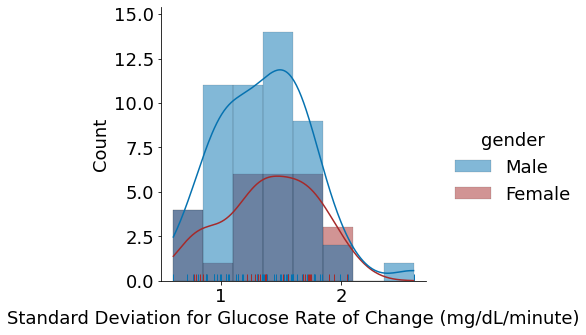

In [18]:
sns.displot(complete_statistics,
            x=complete_statistics['bg_roc_stds'],
            hue=complete_statistics['gender'],
            palette=["#0672B0", "brown"],
            alpha=0.5,
            linewidth=0.1,
            kde=True,
            rug=True)
plt.xlabel('Standard Deviation for Glucose Rate of Change (mg/dL/minute)')

Text(0.5, 15.440000000000012, 'Mean Glucose (mg/dL)')

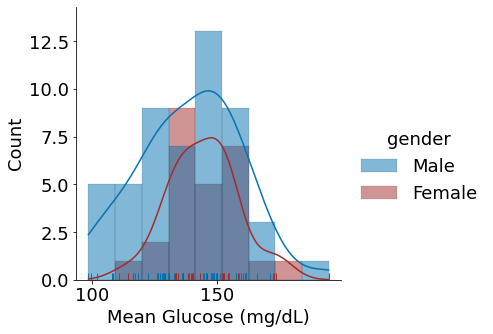

In [19]:
sns.displot(complete_statistics,
            x=complete_statistics['mean'],
            hue=complete_statistics['gender'],
            palette=["#0672B0", "brown"],
            alpha=0.5,
            linewidth=0.1,
            kde=True,
            rug=True)
plt.xlabel('Mean Glucose (mg/dL)')

Text(0.5, 15.440000000000012, 'J_Index')

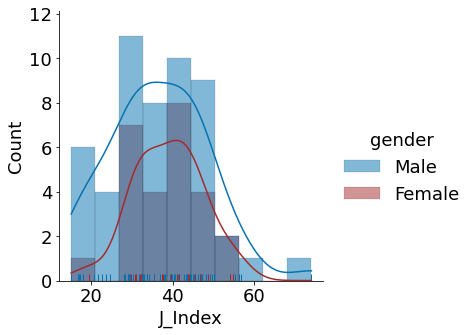

In [20]:
sns.displot(complete_statistics,
            x=complete_statistics['J_index'],
            hue=complete_statistics['gender'],
            palette=["#0672B0", "brown"],
            alpha=0.5,
            linewidth=0.1,
            kde=True,
            rug=True)
plt.xlabel('J_Index')

Text(0.5, 15.440000000000012, 'Low Blood Glucose Index (LBGI)')

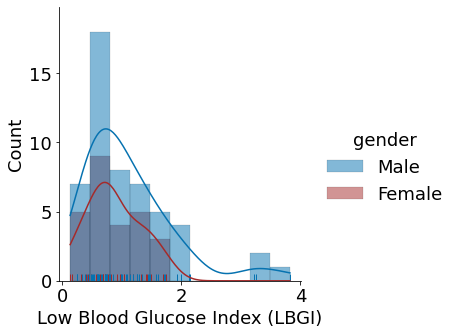

In [21]:
sns.displot(complete_statistics,
            x=complete_statistics['LGBI'],
            hue=complete_statistics['gender'],
            palette=["#0672B0", "brown"],
            alpha=0.5,
            linewidth=0.1,
            kde=True,
            rug=True)
plt.xlabel('Low Blood Glucose Index (LBGI)')

Text(0.5, 15.440000000000012, 'High Blood Glucose Index (HBGI)')

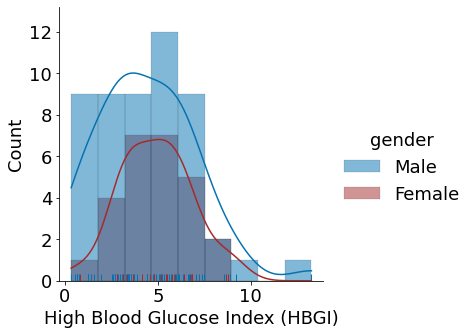

In [22]:
sns.displot(complete_statistics,
            x=complete_statistics['HBGI'],
            hue=complete_statistics['gender'],
            palette=["#0672B0", "brown"],
            alpha=0.5,
            linewidth=0.1,
            kde=True,
            rug=True)
plt.xlabel('High Blood Glucose Index (HBGI)')

Text(0.5, 15.440000000000012, 'Glucose Management Indicator (GMI)')

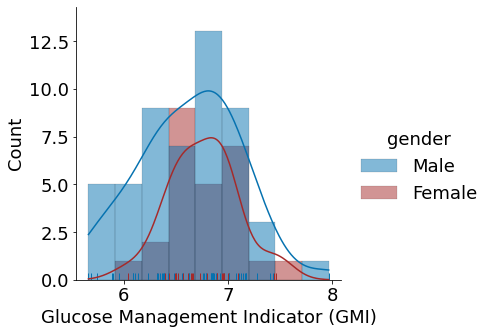

In [23]:
sns.displot(complete_statistics,
            x=complete_statistics['GMI'],
            hue=complete_statistics['gender'],
            palette=["#0672B0", "brown"],
            alpha=0.5,
            linewidth=0.1,
            kde=True,
            rug=True)
plt.xlabel('Glucose Management Indicator (GMI)')

Text(0.5, 15.440000000000012, 'Percentage of Time in Range (TIR)')

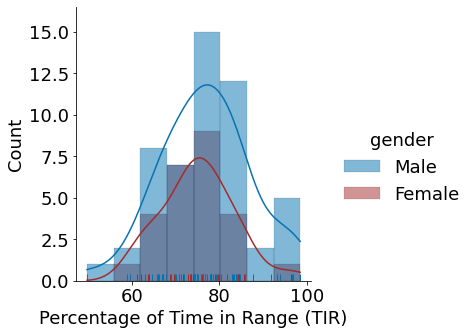

In [24]:
sns.displot(complete_statistics,
            x=complete_statistics['TIR [%]'],
            hue=complete_statistics['gender'],
            palette=["#0672B0", "brown"],
            alpha=0.5,
            linewidth=0.1,
            kde=True,
            rug=True)
plt.xlabel('Percentage of Time in Range (TIR)')

Text(0.5, 15.440000000000012, 'Percentage of Time Outside Range (POR)')

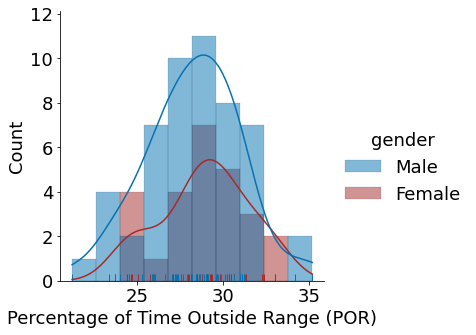

In [25]:
sns.displot(complete_statistics,
            x=complete_statistics['POR'],
            hue=complete_statistics['gender'],
            palette=["#0672B0", "brown"],
            alpha=0.5,
            linewidth=0.1,
            kde=True,
            rug=True)
plt.xlabel('Percentage of Time Outside Range (POR)')

Text(0.5, 15.440000000000012, 'Daily Basal Insulin Units')

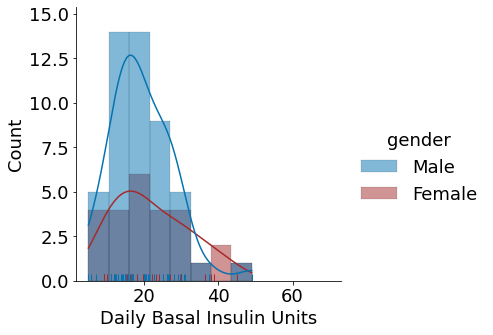

In [26]:
sns.displot(complete_statistics,
            x=complete_statistics['dailyBasalInsulinUnits'],
            hue=complete_statistics['gender'],
            palette=["#0672B0", "brown"],
            alpha=0.5,
            linewidth=0.1,
            kde=True,
            rug=True)
plt.xlabel('Daily Basal Insulin Units')

Text(0.5, 15.440000000000012, 'Daily Insulin Units')

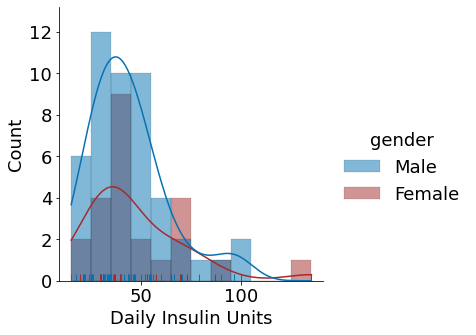

In [27]:
sns.displot(complete_statistics,
            x=complete_statistics['dailyInsulinUnits'],
            hue=complete_statistics['gender'],
            palette=["#0672B0", "brown"],
            alpha=0.5,
            linewidth=0.1,
            kde=True,
            rug=True)
plt.xlabel('Daily Insulin Units')